# Large-scale Matrix Factorization for Music Recommendations

Xiaoyu Lu

The objective of this assignment is to predict personalized music recommendations based on the users' ratings of the music. I used the last.fm dataset, which include a main file of more than 140000 users, 1.5 million unique artists and 24 million users' information regarding how often they played a give song/artist. We also have supplementary files which have the names of artists and artists IDs.

In [2]:
from os import chdir, getcwd
from glob import glob
import numpy as np
import pyspark
import matplotlib.pyplot as plt
from pyspark import SparkContext
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating
from pyspark.mllib.stat import Statistics

%matplotlib inline

In [3]:
path = getcwd()
path = path+'\\RecommenderData\\Recommender 2\\'
#path = path+'\\music_recommender\\music_recommender\\data'
chdir(path)

In [4]:
sc = SparkContext()

The first step is to load the data. The dataset we will be using is distributed by `last.fm` in 2005. Instead of using the entire dataset that has over 140,000 users, 1.5 million unique artists and roughly 24 million users’ information about how often they played a given song/artist, in this tutorial I only use a subset of the dataset, since training the recommendation system means we will have a huge sparse matrix, which requires too much memory this desktop ("only" 32 gb) can handle.


The main dataset is the `user_artist_data_small.txt` file. It contains three columns including user ID, artist ID, and how many times each artist has been played by a specific user. The dataset also gives the names of each artist by ID in the `artist_data.txt file`. When the data was recorded, the names of the artists could be misspelled or non-standard, and this can be detected only later. For example, ‘The Smiths,’ ‘Smiths The’ and ‘he smiths’ may appear as distinct artist IDs, but they refer to the same artist. So, the dataset also includes artist `alias.txt` dataset, which maps the artist IDs that are known to be misspelled or variants to the canonical ID of the artist.

In [6]:
alias = sc.textFile('artist_alias_small.txt').map(lambda x: x.split('\t'))
artist = sc.textFile("artist_data_small.txt").map(lambda x: x.split('\t'))

In [7]:
alias_dict = alias.collectAsMap()
artist_dict = artist.collectAsMap()

alias_dict and artist_dict are two dictionaries that are converted from the paired-rdds. This helps with future processing to map artists' real names to their IDs.

In [9]:
userartist = sc.textFile('user_artist_data_small.txt')
alias_dict = alias.collectAsMap()
artist_dict = artist.collectAsMap()

def replace_alias(line):
    records = line.split(' ')
    if records[1] in alias_dict.keys():
        records[1] = alias_dict[records[1]]
    return(records)

userartist = userartist.map(replace_alias)

replace_alias is a user defined function to replace wrong IDs of artists with their true ones that are in alias_dict.

In [8]:
summary = Statistics.colStats(userartist)
maxID_UA = summary.max()[:2]

if np.any(maxID_UA) > 2147483647:
    print('Max ID greater than limitation.')
else:
    print('ID meets requirement.')
    
def add_artist(line):
    line.insert(2, artist_dict[line[1]])
    return(line)

userartist = userartist.map(lambda x: [x[0], x[1], float(x[2])])
print ("length of cleaned data:", userartist.count())

userartist_name = userartist.map(add_artist)
print("First 10 items:", userartist_name.take(10))

ID meets requirement.
length of cleaned data: 49481
First 10 items: [['1059637', '1000010', 'Aerosmith', 238.0], ['1059637', '1000049', "Edna's Goldfish", 1.0], ['1059637', '1000056', 'The Mighty Mighty Bosstones', 1.0], ['1059637', '1000062', 'Foo Fighters', 11.0], ['1059637', '1000094', 'The Bouncing Souls', 1.0], ['1059637', '1000112', 'Alkaline Trio', 423.0], ['1059637', '1000113', 'The Beatles', 5.0], ['1059637', '1000114', 'Pennywise', 2.0], ['1059637', '1000123', 'Incubus', 2.0], ['1059637', '1000130', 'Bright Eyes', 19129.0]]


The maximum value of the ID is less than 2147483647, the largest numerical value that we can handle. So we are all set.

First, let's take a look at the first 10 items in the userartist RDD.

In [9]:
userartist.take(10)

[['1059637', '1000010', 238.0],
 ['1059637', '1000049', 1.0],
 ['1059637', '1000056', 1.0],
 ['1059637', '1000062', 11.0],
 ['1059637', '1000094', 1.0],
 ['1059637', '1000112', 423.0],
 ['1059637', '1000113', 5.0],
 ['1059637', '1000114', 2.0],
 ['1059637', '1000123', 2.0],
 ['1059637', '1000130', 19129.0]]

It can be seen that the user IDs and artist IDs are all strings. To train the model, we need to convert these strings to integers. 

In [10]:
users = userartist.map(lambda x: x[0]).distinct().zipWithIndex()
artists = userartist.map(lambda x: x[1]).distinct().zipWithIndex()

The users and artists are two rdds that stores the key-value pairs of the ID of user/artist and their corresponding index as an integer. Let's take a look at the first 10 items in the users RDD.

In [11]:
users.take(10)

[('1059637', 0),
 ('2069337', 1),
 ('2023977', 2),
 ('1046559', 3),
 ('1052461', 4),
 ('2020513', 5),
 ('2062243', 6),
 ('1001440', 7),
 ('2017397', 8),
 ('1024631', 9)]

Let's now map the indices of users and artist to the original dataset. 

In [ ]:
userartist = userartist.map(lambda r: (r[0], (r[1], r[2]))).join(users).map(lambda r: (r[1][1], r[1][0][0], r[1][0][1]))
userartist = userartist.map(lambda r: (r[1], (r[0], r[2]))).join(artists).map(lambda r: (r[1][0][0], r[1][1], r[1][0][1]))

After the mapping, the data now has three columns, including user index, artist index, and how many times the artist has been played by the user. Let's take a look.

In [13]:
userartist.take(10)

[(1, 1, 15177.0),
 (7, 1, 3.0),
 (18, 1, 9.0),
 (21, 1, 6.0),
 (23, 1, 1.0),
 (25, 1, 22.0),
 (47, 1, 364.0),
 (0, 1, 1.0),
 (12, 1, 67.0),
 (16, 1, 116.0)]

We will convert the format of each column to int, int, and float. Also use the Rating function to convert the RDD to a Rating class, which is required by the Absolute Least Squares (ALS) function in spark.

In [15]:
userartist = userartist.map(lambda l: Rating(int(l[0]), int(l[1]), float(l[2])))

In [16]:
userartist.take(10)

[Rating(user=1, product=1, rating=15177.0),
 Rating(user=7, product=1, rating=3.0),
 Rating(user=18, product=1, rating=9.0),
 Rating(user=21, product=1, rating=6.0),
 Rating(user=23, product=1, rating=1.0),
 Rating(user=25, product=1, rating=22.0),
 Rating(user=47, product=1, rating=364.0),
 Rating(user=0, product=1, rating=1.0),
 Rating(user=12, product=1, rating=67.0),
 Rating(user=16, product=1, rating=116.0)]

Four parameters will influence the performance of the model, including rank, interation, lambda, and alpha. 

* **rank** is the number of features to use (also referred to as the number of latent factors).
* **iterations** is the number of iterations of ALS to run. ALS typically converges to a reasonable solution in 20 iterations or less.
* **lambda** specifies the regularization parameter in ALS.
* **alpha** is a parameter applicable to the implicit feedback variant of ALS that governs the baseline confidence in preference observations.

In [17]:
rank = 10
iteration = 5
lambda_ = 0.01
alpha = 1.0

Two ALS models are available in `spark.mllib`. One is the standard approach to matrix factorization based collaborative filtering. This method treats the entries in the user-item matrix as explicit preferences given by the user to the item, for example, users giving ratings to movies.

It is common in many real-world use cases to only have access to implicit feedback (e.g. views, clicks, purchases, likes, shares etc.). The approach used in `spark.mllib` to deal with such data is taken from Collaborative Filtering for Implicit Feedback Datasets. Essentially, instead of trying to model the matrix of ratings directly, this approach treats the data as numbers representing the strength in observations of user actions (such as the number of clicks, or the cumulative duration someone spent viewing a movie). Those numbers are then related to the level of confidence in observed user preferences, rather than explicit ratings given to items. The model then tries to find latent factors that can be used to predict the expected preference of a user for an item.

In the former case, it is suggested to use the `ALS.train` function to train the model; in the latter case, it is suggested to use the `ALS.trainImplicit` function to train the model.

In [18]:
model = ALS.trainImplicit(userartist, rank=rank, iterations=iteration,lambda_=lambda_,alpha=alpha)

In [19]:
userartist4prediction = userartist.map(lambda x: (x[0], x[1]))
predictions = model.predictAll(userartist4prediction).map(lambda r: ((r[0], r[1]), r[2]))

In [20]:
predictions.take(10)

[((9, 4904), 0.7480419721892768),
 ((9, 18624), 0.6858364748781163),
 ((19, 9200), 0.7905168770163249),
 ((16, 16408), 1.0066523448246976),
 ((48, 16408), 0.9253115167053222),
 ((9, 16408), 1.1027148221016088),
 ((34, 16408), 0.647037422525083),
 ((18, 16408), 0.6808103485507488),
 ((26, 16408), 1.1176582746972676),
 ((13, 16408), 0.5702556075150521)]

We will map the predictions to the original plays to evaluate our model.

In [22]:
rates_and_preds = userartist.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)

The four columns in rates_and_preds include user ID, artist ID, number of plays, and the predicted results.

In [23]:
rates_and_preds.take(5)

[((7, 1), (3.0, 1.445892974824985)),
 ((4, 184), (1487.0, 1.0140836288565107)),
 ((26, 184), (97.0, 1.1491636704064594)),
 ((46, 34), (110.0, 0.9458580007784194)),
 ((49, 197), (33.0, 0.9631232049558082))]

The predict_user function will create a plot comparing the predicted ratings and the original values. The plot will also be saved as a .png file.

In [24]:
def predict_user(user_id):
    user2pred = users.filter(lambda x: x[0] == user_id)
    user_index = user2pred.collect()[0][1]
    obs_pred = rates_and_preds.filter(lambda x: x[0][0] == user_index).map(lambda x: (x[1][0], x[1][1]))
    x = obs_pred.map(lambda x:x[0]).collect()
    y = obs_pred.map(lambda x:x[1]).collect()
    plt.scatter(x, y, marker='x', s=12)
    plt.title('user: {0}'.format(user_id))
    plt.xlabel('real ratings (logscale)')
    plt.ylabel('predictions')

    plt.xscale('log')
    plt.savefig('{0}.png'.format(user_id))

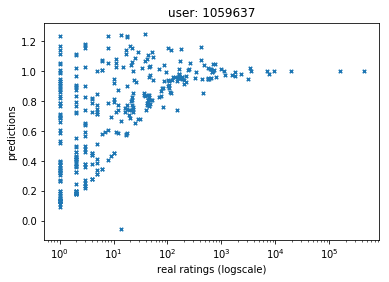

In [25]:
predict_user('1059637')

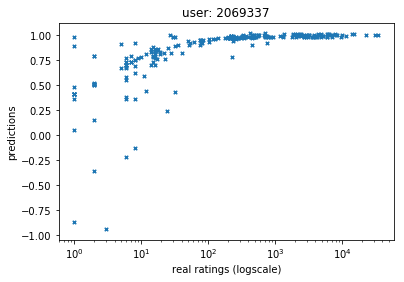

In [26]:
predict_user('2069337')

Generally, artists that has lower plays yield lower predictions, and the ones with more plays shows higher predictions. However, this is only a visual comparison. A good way to quantitatively assess the model is to calculate the Mean Squared Error (MSE).

In [27]:
def getmse(model, data):
    data_for_predict = data.map(lambda x:(x[0], x[1]))
    predictions = model.predictAll(data_for_predict).map(lambda x: ((x[0], x[1]), x[2]))
    rates_and_preds = data.map(lambda x: ((int(x[0]), int(x[1])), float(x[2]))).join(predictions)
    mse = rates_and_preds.map(lambda x:(x[1][0] - x[1][1])**2).mean()
    return mse

We will split the data 9:1 into the training and testing set, and using the function above to produce the mse to assess the performance of the ALS model. 

In [28]:
rdd_train, rdd_test = userartist.randomSplit([9, 1])
model = ALS.trainImplicit(rdd_train, rank=rank, iterations=iteration,lambda_=lambda_,alpha=alpha)
mse = getmse(model, rdd_test)
print("Mean Squared Error = {0}".format(mse))

Mean Squared Error = 570414.5683493328


We can also tune the parameters using the cross-validation. Below is an example.

In [29]:
ranks = [10, 50]
lambda_s = [1.0, 0.0001]
alphas = [1.0, 40.0]
interation = 10

In [30]:
min_mse = np.inf
best_rank = 0
best_lambda_ = 0
best_alpha = 0

for rank in ranks:
    for lambda_ in lambda_s:
        for alpha in alphas:
            model = ALS.trainImplicit(rdd_train, rank=rank, iterations=iteration,lambda_=lambda_,alpha=alpha)
            mse = getmse(model, rdd_test)
            if mse < min_mse:
                min_mse = mse
                best_rank = rank
                best_lambda_ = lambda_
                best_alpha = alpha
print("best parameters: rank = {0}, lambda = {1}, alpha = {2}".format(best_rank, best_lambda_, best_alpha))
print("minimum mse: {0}".format(min_mse))

best parameters: rank = 10, lambda = 0.0001, alpha = 1.0
minimum mse: 570425.4738342189
